In [3]:
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from sklearn.metrics import confusion_matrix
import numpy as np

from glob import glob

In [4]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPU


In [5]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [6]:
IMAGE_SIZE = [100, 100]
epochs = 15
batch_size = 128


In [7]:
BASE_PATH = "C:\\Users\\sktsa\Datasets\\fruits-360_dataset\\fruits-360\\"
TRAIN_PATH = BASE_PATH + 'Training'
TEST_PATH = BASE_PATH + 'Test'

In [8]:
image_files = glob(TRAIN_PATH + '/*/*.jp*g')
image_test_files = glob(TEST_PATH + '/*/*.jp*g')

In [9]:
folders = glob(TRAIN_PATH + '/*')

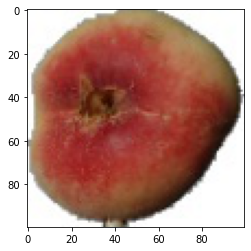

In [10]:
import matplotlib.pyplot as plt

plt.imshow(image.load_img(np.random.choice(image_files)))

In [11]:
res_base = ResNet50(input_shape=IMAGE_SIZE + [3],
                    weights='imagenet',
                    include_top=False)
for layer in res_base.layers:
    layer.trainable = False

In [12]:
x = Flatten()(res_base.output)
prediction = Dense(len(folders), activation='softmax')(x)

In [13]:
model = Model(inputs=res_base.input, outputs=prediction)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [15]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [16]:
train_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [17]:
test_gen = val_gen.flow_from_directory(TEST_PATH, target_size=IMAGE_SIZE)
print(test_gen.class_indices)

Found 22688 images belonging to 131 classes.
{'Apple Braeburn': 0, 'Apple Crimson Snow': 1, 'Apple Golden 1': 2, 'Apple Golden 2': 3, 'Apple Golden 3': 4, 'Apple Granny Smith': 5, 'Apple Pink Lady': 6, 'Apple Red 1': 7, 'Apple Red 2': 8, 'Apple Red 3': 9, 'Apple Red Delicious': 10, 'Apple Red Yellow 1': 11, 'Apple Red Yellow 2': 12, 'Apricot': 13, 'Avocado': 14, 'Avocado ripe': 15, 'Banana': 16, 'Banana Lady Finger': 17, 'Banana Red': 18, 'Beetroot': 19, 'Blueberry': 20, 'Cactus fruit': 21, 'Cantaloupe 1': 22, 'Cantaloupe 2': 23, 'Carambula': 24, 'Cauliflower': 25, 'Cherry 1': 26, 'Cherry 2': 27, 'Cherry Rainier': 28, 'Cherry Wax Black': 29, 'Cherry Wax Red': 30, 'Cherry Wax Yellow': 31, 'Chestnut': 32, 'Clementine': 33, 'Cocos': 34, 'Corn': 35, 'Corn Husk': 36, 'Cucumber Ripe': 37, 'Cucumber Ripe 2': 38, 'Dates': 39, 'Eggplant': 40, 'Fig': 41, 'Ginger Root': 42, 'Granadilla': 43, 'Grape Blue': 44, 'Grape Pink': 45, 'Grape White': 46, 'Grape White 2': 47, 'Grape White 3': 48, 'Grape Wh

In [18]:
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k

(32, 100, 100, 3) (32, 131)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min:  -105.68 max:  151.061


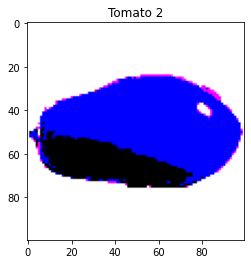

In [19]:
for x, y in test_gen:
    print(x.shape, y.shape)
    print('min: ', x[0].min(), 'max: ', x[0].max())
    plt.title(labels[np.argmax([y[0]])])
    plt.imshow(x[0])
    plt.show()
    break

In [20]:
train_generator = train_gen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size,
    class_mode='sparse',
)

val_generator = val_gen.flow_from_directory(
    TEST_PATH,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size,
    class_mode='sparse',
)

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [21]:
r = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=len(image_files) // batch_size,
    validation_steps=len(image_test_files) // batch_size
)

Epoch 1/15
528/528 [==============================] - 236s 431ms/step - loss: 0.7861 - accuracy: 0.9144 - val_loss: 1.0947 - val_accuracy: 0.9233
Epoch 2/15
528/528 [==============================] - 213s 402ms/step - loss: 0.2872 - accuracy: 0.9714 - val_loss: 1.0737 - val_accuracy: 0.9408
Epoch 3/15
528/528 [==============================] - 184s 347ms/step - loss: 0.2334 - accuracy: 0.9795 - val_loss: 0.5125 - val_accuracy: 0.9639
Epoch 4/15
528/528 [==============================] - 182s 345ms/step - loss: 0.2316 - accuracy: 0.9829 - val_loss: 0.5733 - val_accuracy: 0.9645
Epoch 5/15
528/528 [==============================] - 202s 383ms/step - loss: 0.1907 - accuracy: 0.9869 - val_loss: 0.3383 - val_accuracy: 0.9821
Epoch 6/15
528/528 [==============================] - 388s 735ms/step - loss: 0.1769 - accuracy: 0.9882 - val_loss: 0.8391 - val_accuracy: 0.9722
Epoch 7/15
528/528 [==============================] - 183s 347ms/step - loss: 0.1591 - accuracy: 0.9905 - val_loss: 1.3304 -

In [23]:
import seaborn as sns
import pandas as pd
df = pd.DataFrame.from_dict(r.history)

In [26]:
r.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [28]:
df

,loss,accuracy,val_loss,val_accuracy
0,0.786060,0.914437,1.094730,0.923287
1,0.287153,0.971361,1.073677,0.940810
2,0.233425,0.979531,0.512533,0.963851
3,0.231602,0.982875,0.573254,0.964513
4,0.190652,0.986872,0.338253,0.982124
5,0.176914,0.988189,0.839083,0.972237
6,0.159080,0.990528,1.330364,0.957892
7,0.165910,0.990601,0.974526,0.970074
8,0.143325,0.991919,0.674592,0.978152
9,0.182185,0.991549,0.889145,0.978107


<AxesSubplot:>

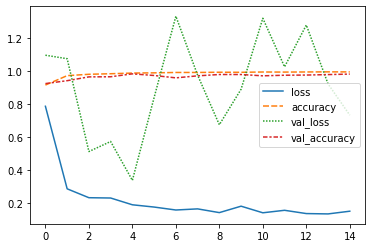

In [29]:
sns.lineplot(data=df)